# Classificação com Kmeans

Vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo é tentar agrupar os clientes conforme seu comportamento de navegação entre páginas administrativas, informativas e de produtos. 

As variáveis estão descritas abaixo (em tradução livre do link indicado).

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [32]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm

In [22]:
df = pd.read_csv('online_shoppers_intention.csv')

In [23]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [24]:
df.Revenue.value_counts(dropna=False)

False    10422
True      1908
Name: Revenue, dtype: int64

## Análise descritiva

- Verifique a distribuição dessas variáveis


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [26]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


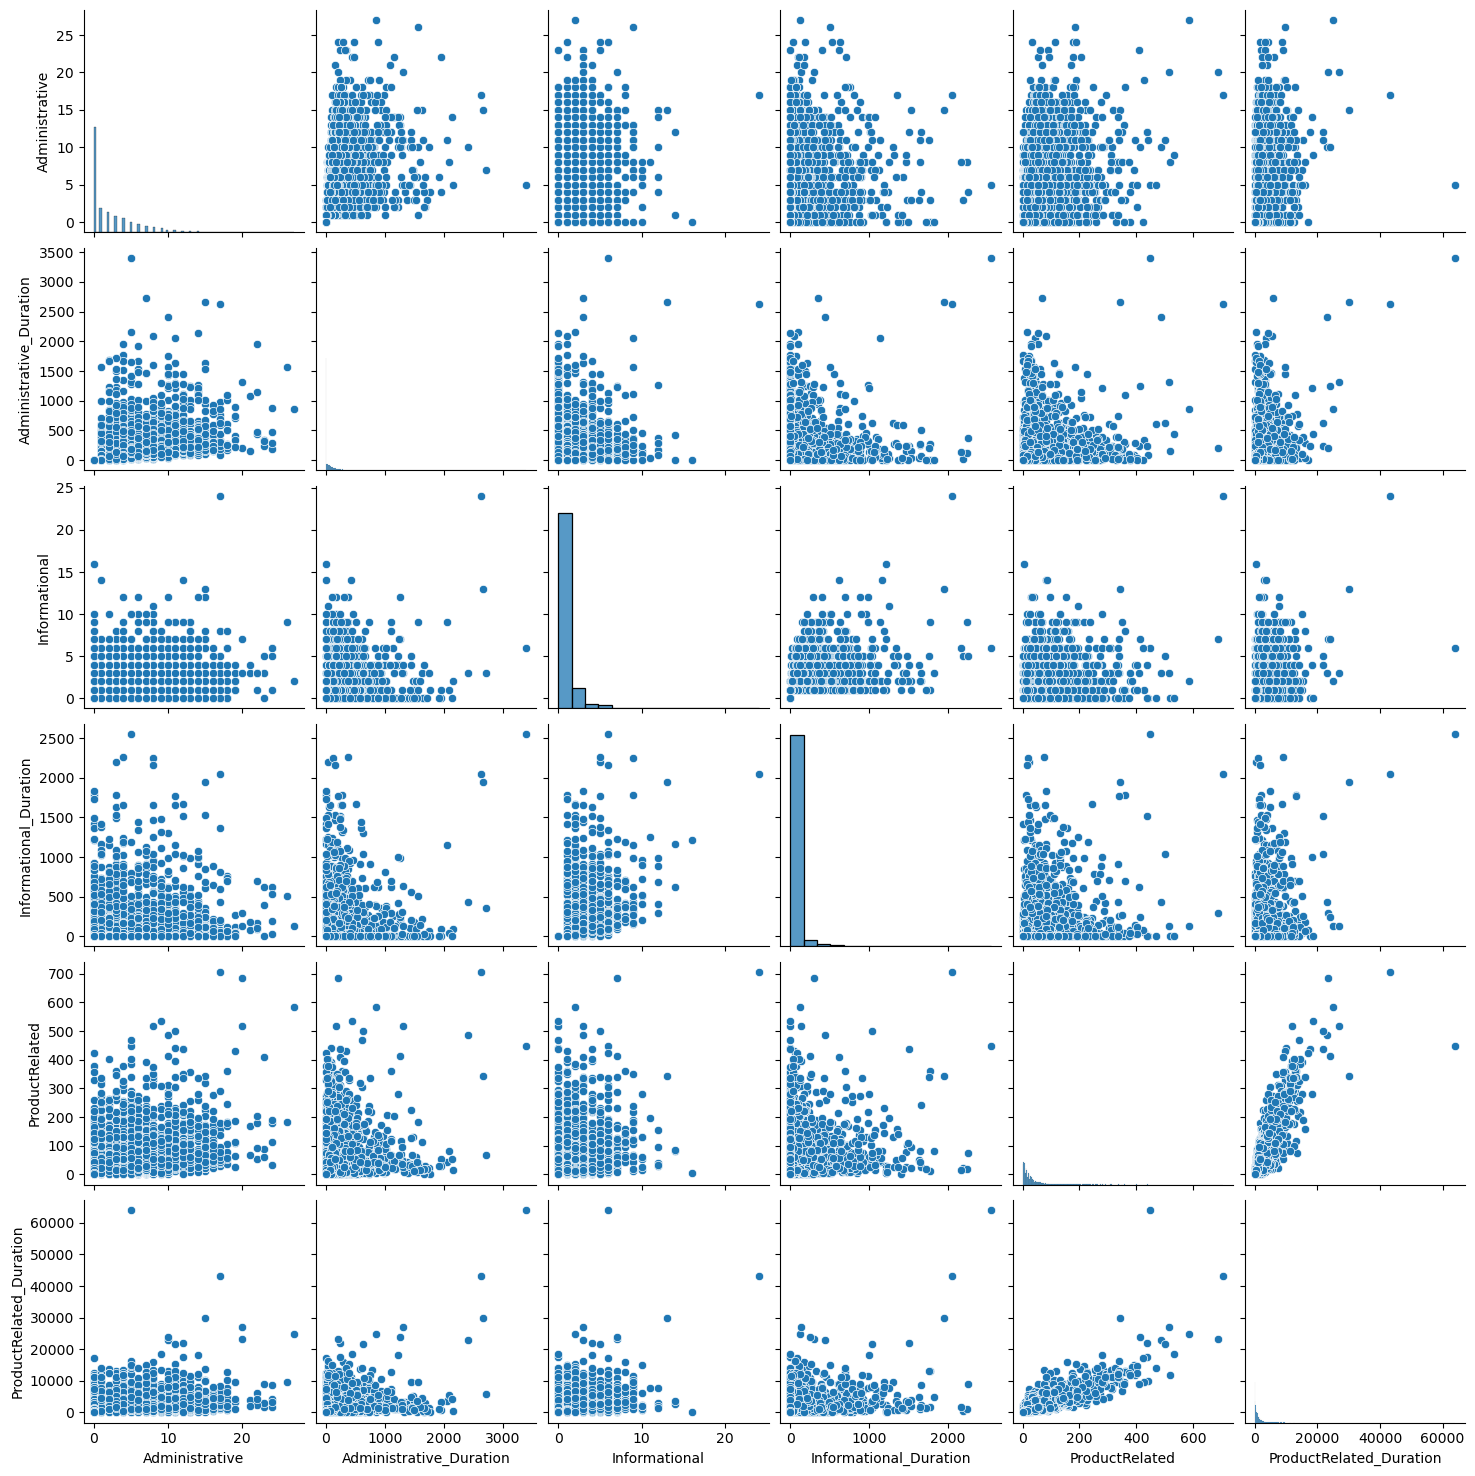

In [27]:
# Variáveis que vão ser utilizadas
variaveis = ["Administrative", "Administrative_Duration", "Informational", 
             "Informational_Duration", "ProductRelated", "ProductRelated_Duration"]
df_var = df[variaveis].copy()
sns.pairplot(df_var)

In [28]:
# Aplicando a padronização nas variáveis
df_pad = pd.DataFrame(StandardScaler().fit_transform(df[variaveis]), columns = df[variaveis].columns)
df_pad.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430


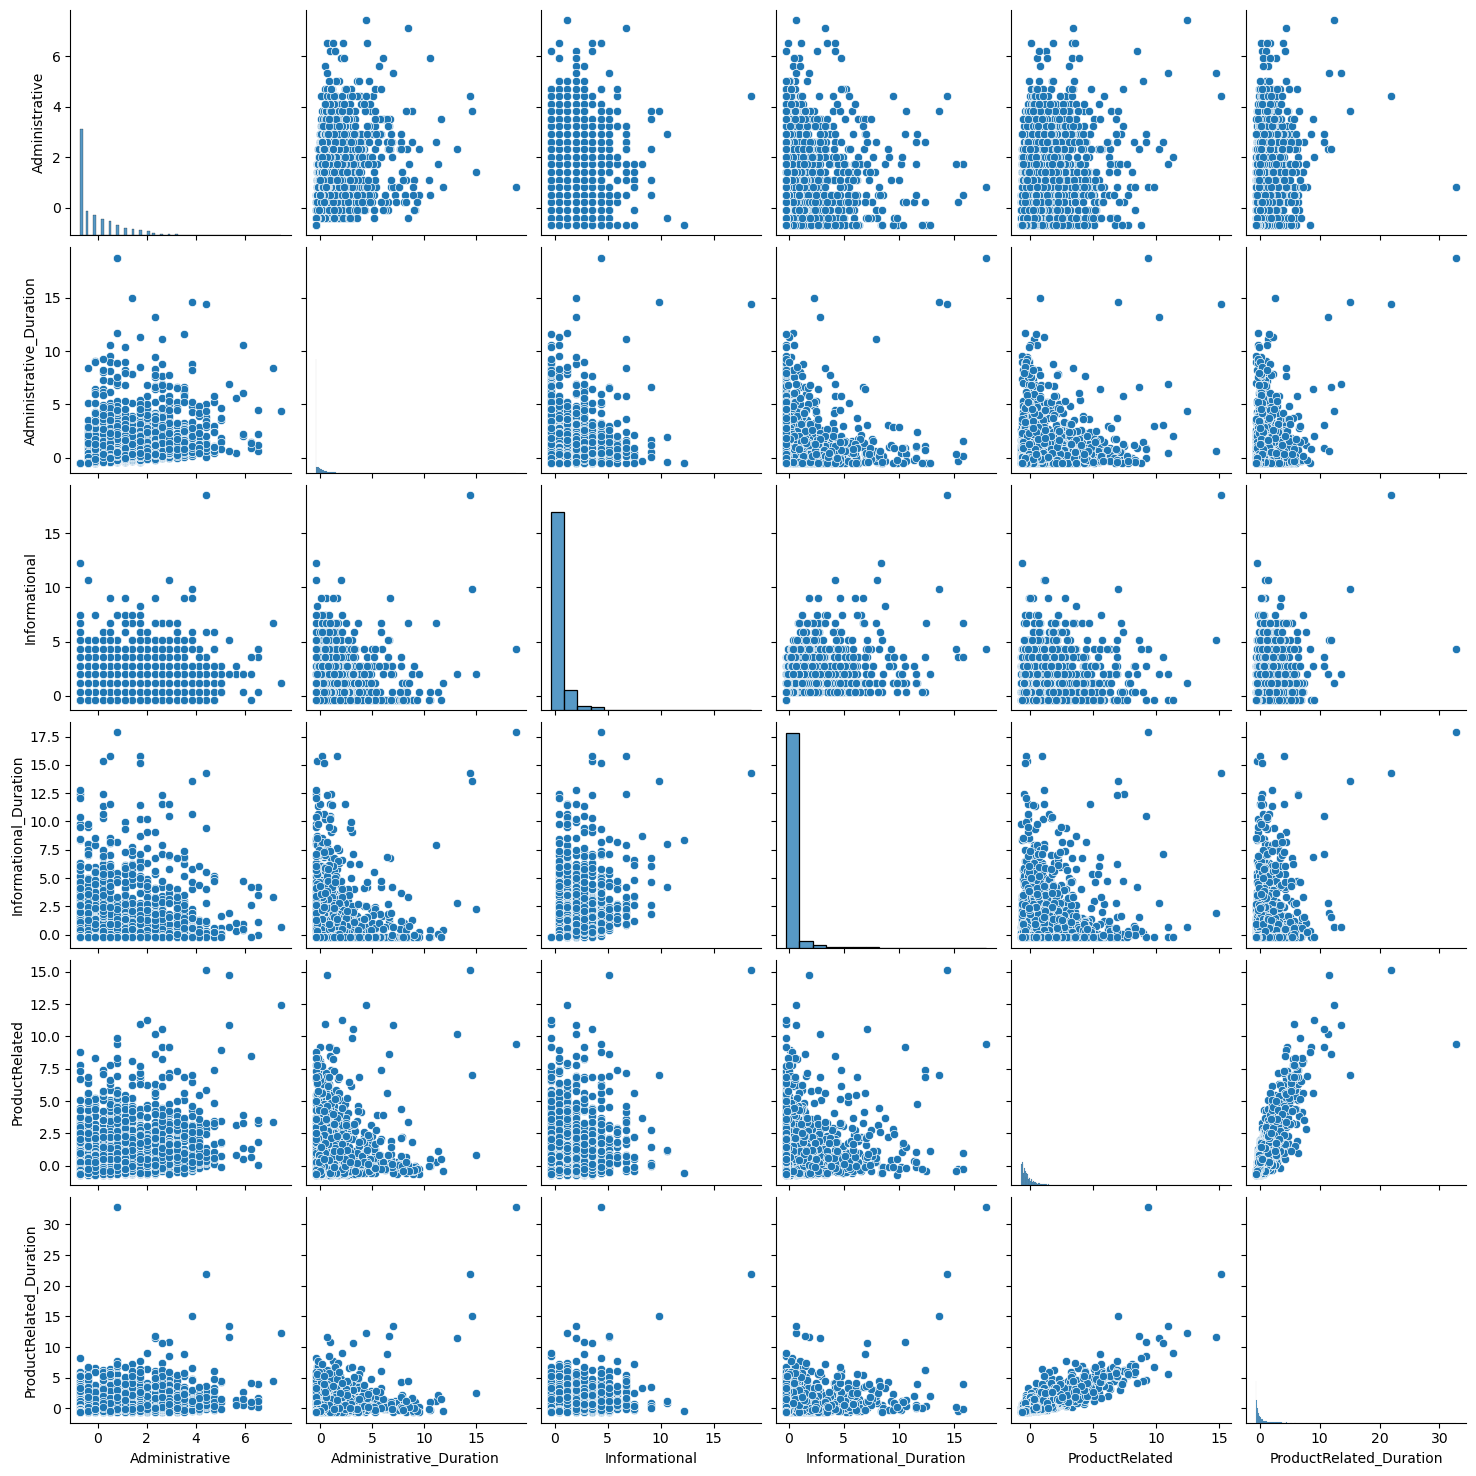

In [29]:
sns.pairplot(df_pad)

- Veja se há valores *missing* 

In [30]:
df.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

## Número de grupos

### Método do cotovelo

  0%|          | 0/14 [00:00<?, ?it/s]

C:\Users\Artur\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Artur\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Artur\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Artur\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Artur\anaconda3\lib\site-packages\sklearn\clust

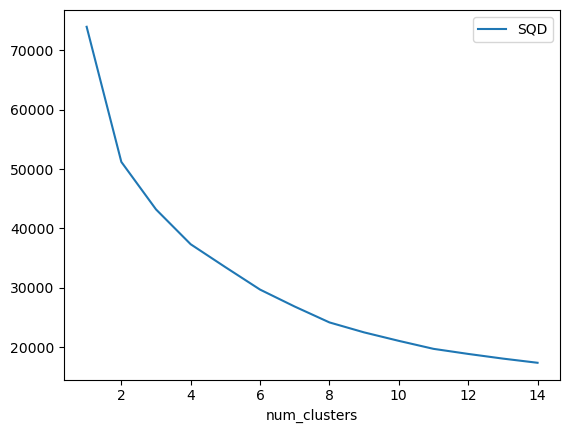

In [33]:
SQD = []

# Número de cluster que estamos considerando
K = range(1,15)
#Laço de repetição e inserindo barra de progresso
for k in tqdm(K):
    # Fazendo um agrupamento para cada possibilidade de clusters
    km = KMeans(n_clusters=k)
    # Fazendo o fit()
    km = km.fit(df_pad)
    # Acrescentando a lista SQD. 
    # O atributo inertia_ do cluster fitado(é a soma dos quadrados das distância (SQD))
    SQD.append(km.inertia_)
    
# Plotando gráfico num_clusters x SQD
df_graf = pd.DataFrame({'num_clusters': list(range(1, len(SQD)+1)), 'SQD': SQD})
df_graf.plot(x = 'num_clusters', y = 'SQD')
plt.show()

### Coeficiente de Silhueta

  0%|          | 0/9 [00:00<?, ?it/s]

C:\Users\Artur\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Artur\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Artur\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Artur\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Artur\anaconda3\lib\site-packages\sklearn\clust

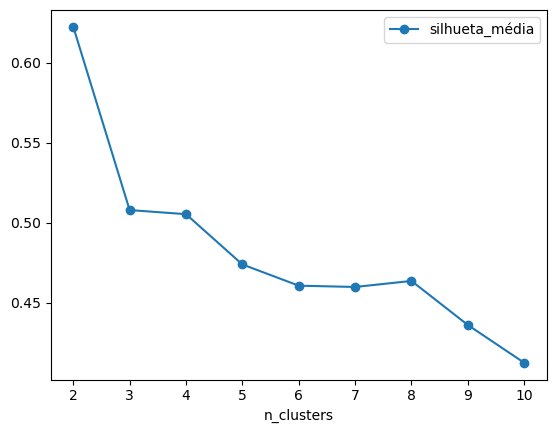

In [34]:
# Inicializar uma lista vazia que vai conter os valores da silhueta média
silhuetas = []
# Este é o número máximo de grupos que vamos testar
max_clusters = 10

# O loop percorre de 2 até o máximo de clusters
for n_clusters in tqdm(range(2, max_clusters+1)):
    # Aqui rodamos o k-means
    km = KMeans(n_clusters=n_clusters).fit(df_pad)
    # Aqui calculamos a silhueta e guardamos o resultado na lista 'silhuetas'
    silhuetas.append(silhouette_score(df_pad, km.labels_))
    
# Plotando os dados de silhueta média
df_silhueta = pd.DataFrame({'n_clusters': list(range(2, max_clusters+1)), 'silhueta_média': silhuetas})

df_silhueta.plot.line(x = 'n_clusters', y = 'silhueta_média', marker='o')
plt.show()
# plt.scatter(x = df_silhueta.n_clusters, y = df_silhueta.silhueta_média)

Pelos dois métodos, a melhor opção seria utilizar 2 grupos. Mas podemos testar com 3 ou 4 grupos também e analisar se está mais apropriado ao objetivo de negócio.

## Avaliação dos grupos

Análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.

C:\Users\Artur\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


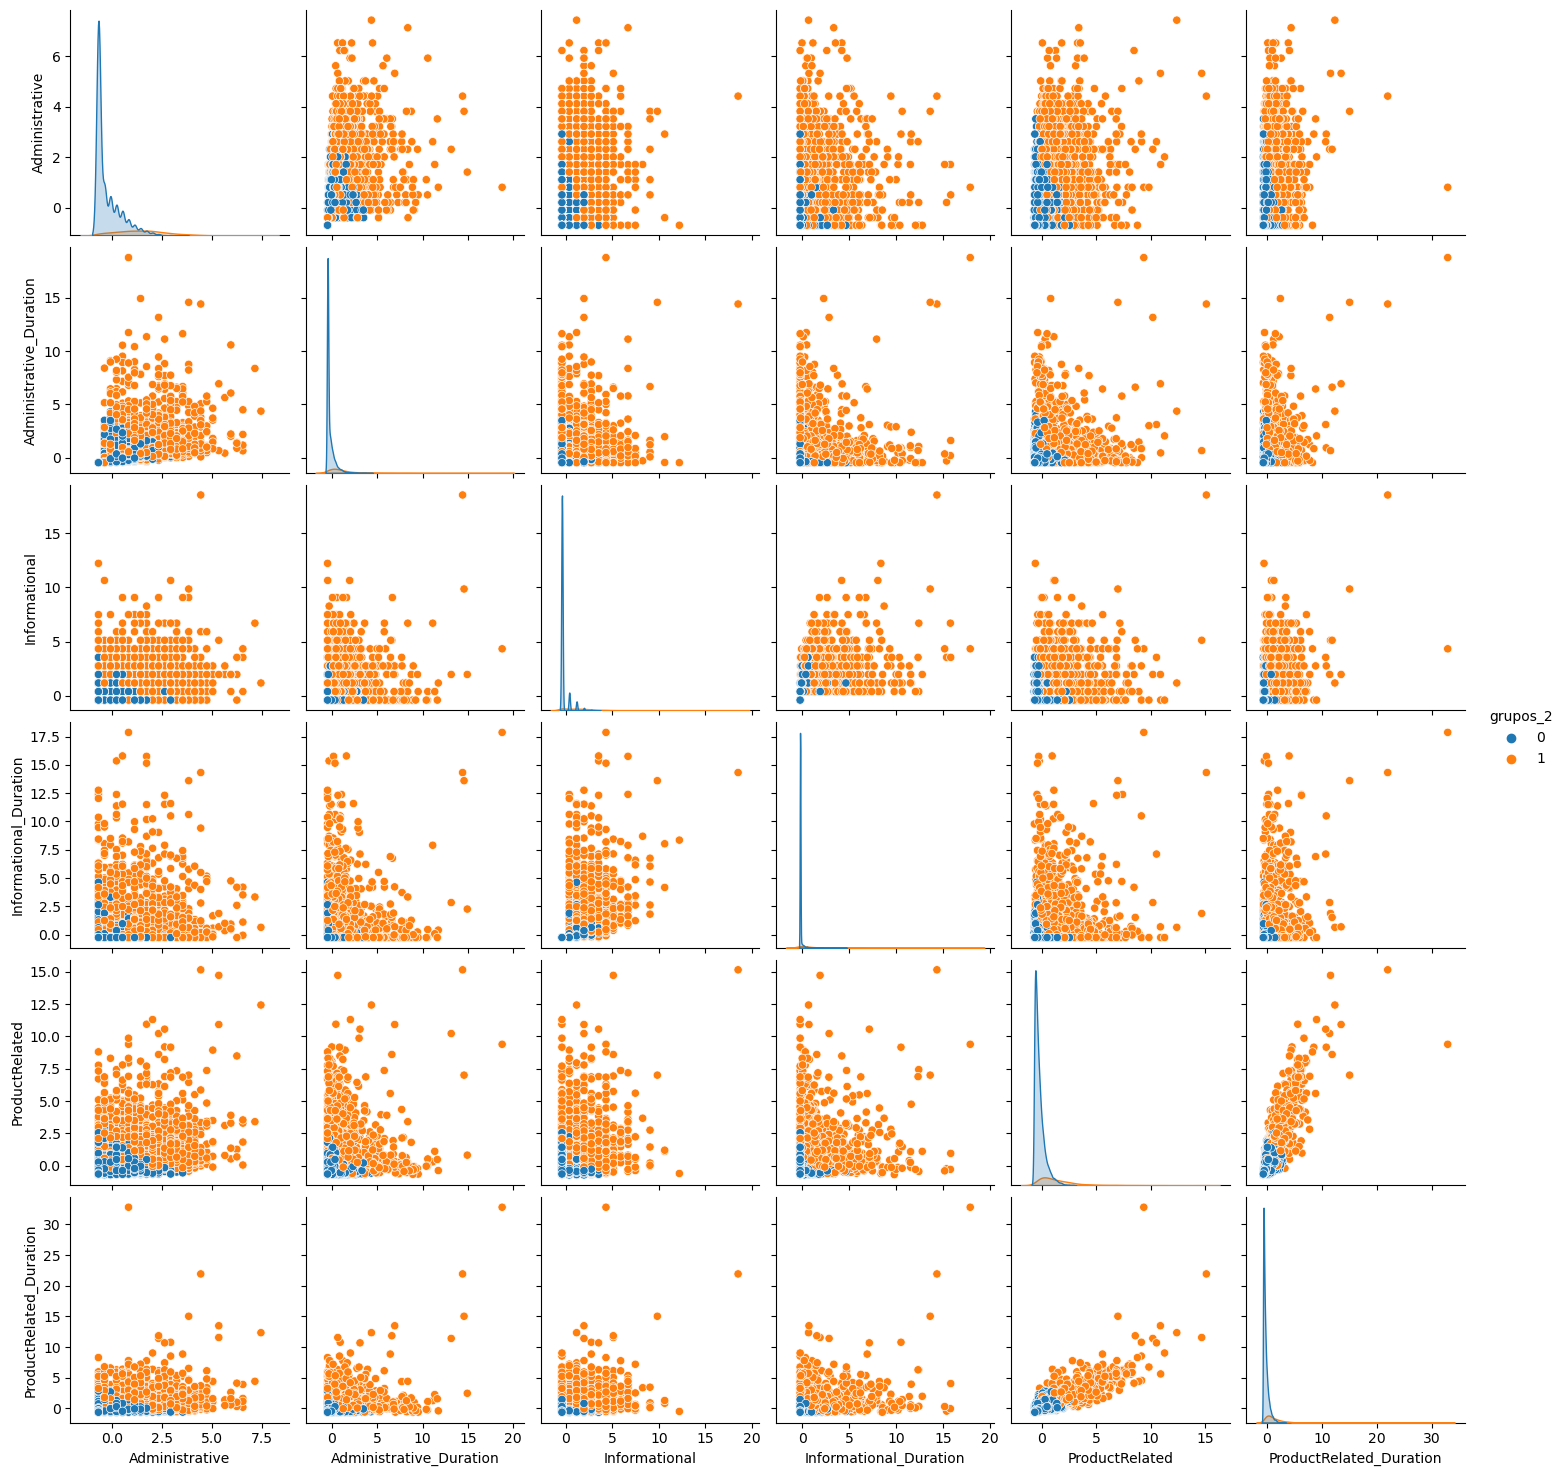

In [35]:
# Rodando algoritmo de clusterização (KMeans) para 2 clusters
cluster_2 = KMeans(n_clusters=2)
cluster_2.fit_predict(df_pad)

# Adicionando uma coluna no dataframe df_pad com o agrupamento construido
df_pad['grupos_2'] = pd.Categorical(cluster_2.labels_)

# Plotando resultado
sns.pairplot(df_pad, hue='grupos_2')
plt.show()

C:\Users\Artur\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


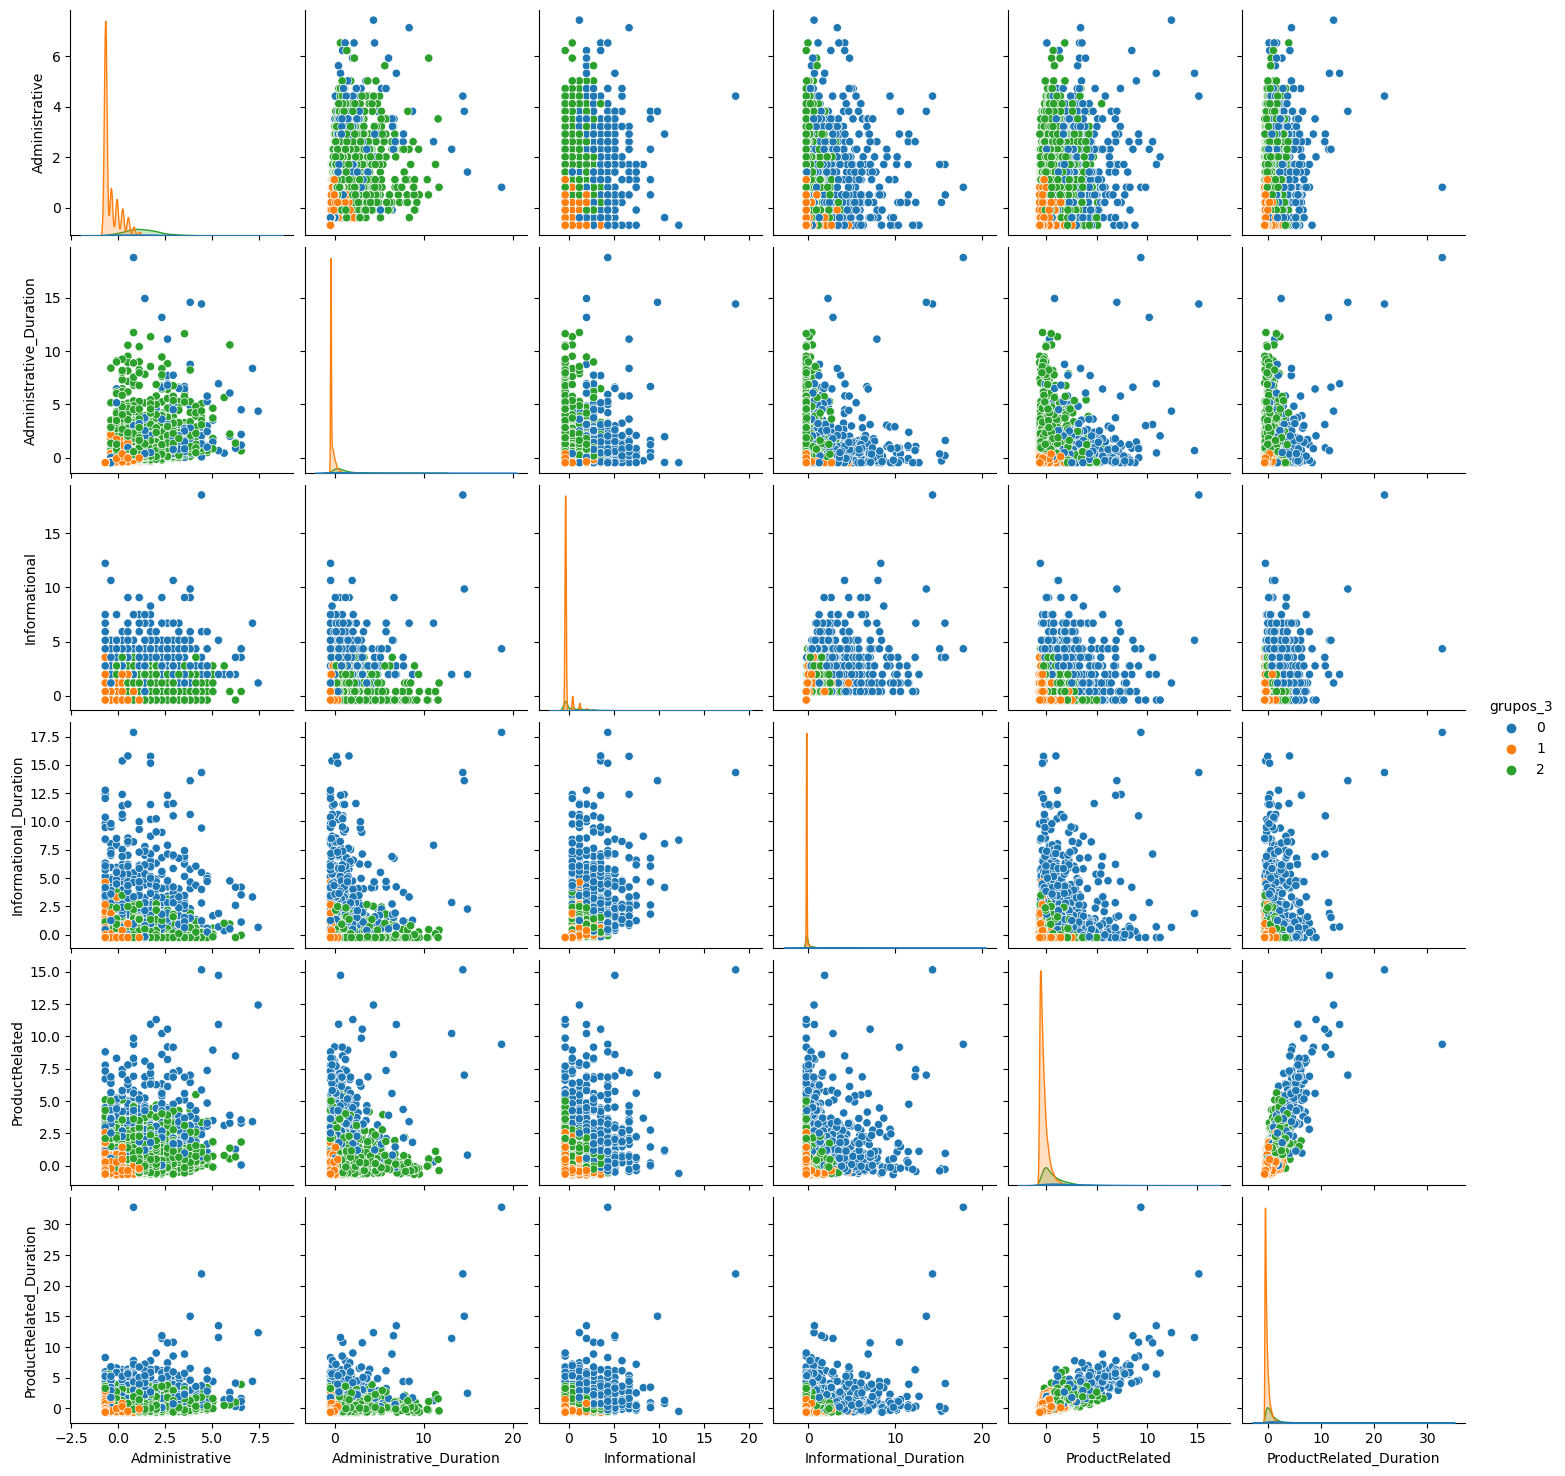

In [36]:
# Rodando algoritmo de clusterização (KMeans) para 3 clusters
cluster_3 = KMeans(n_clusters=3)
cluster_3.fit_predict(df_pad)

# Adicionando uma coluna no dataframe df_pad com o agrupamento construido
df_pad['grupos_3'] = pd.Categorical(cluster_3.labels_)

# Plotando resultado
sns.pairplot(df_pad, hue='grupos_3')
plt.show()

C:\Users\Artur\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


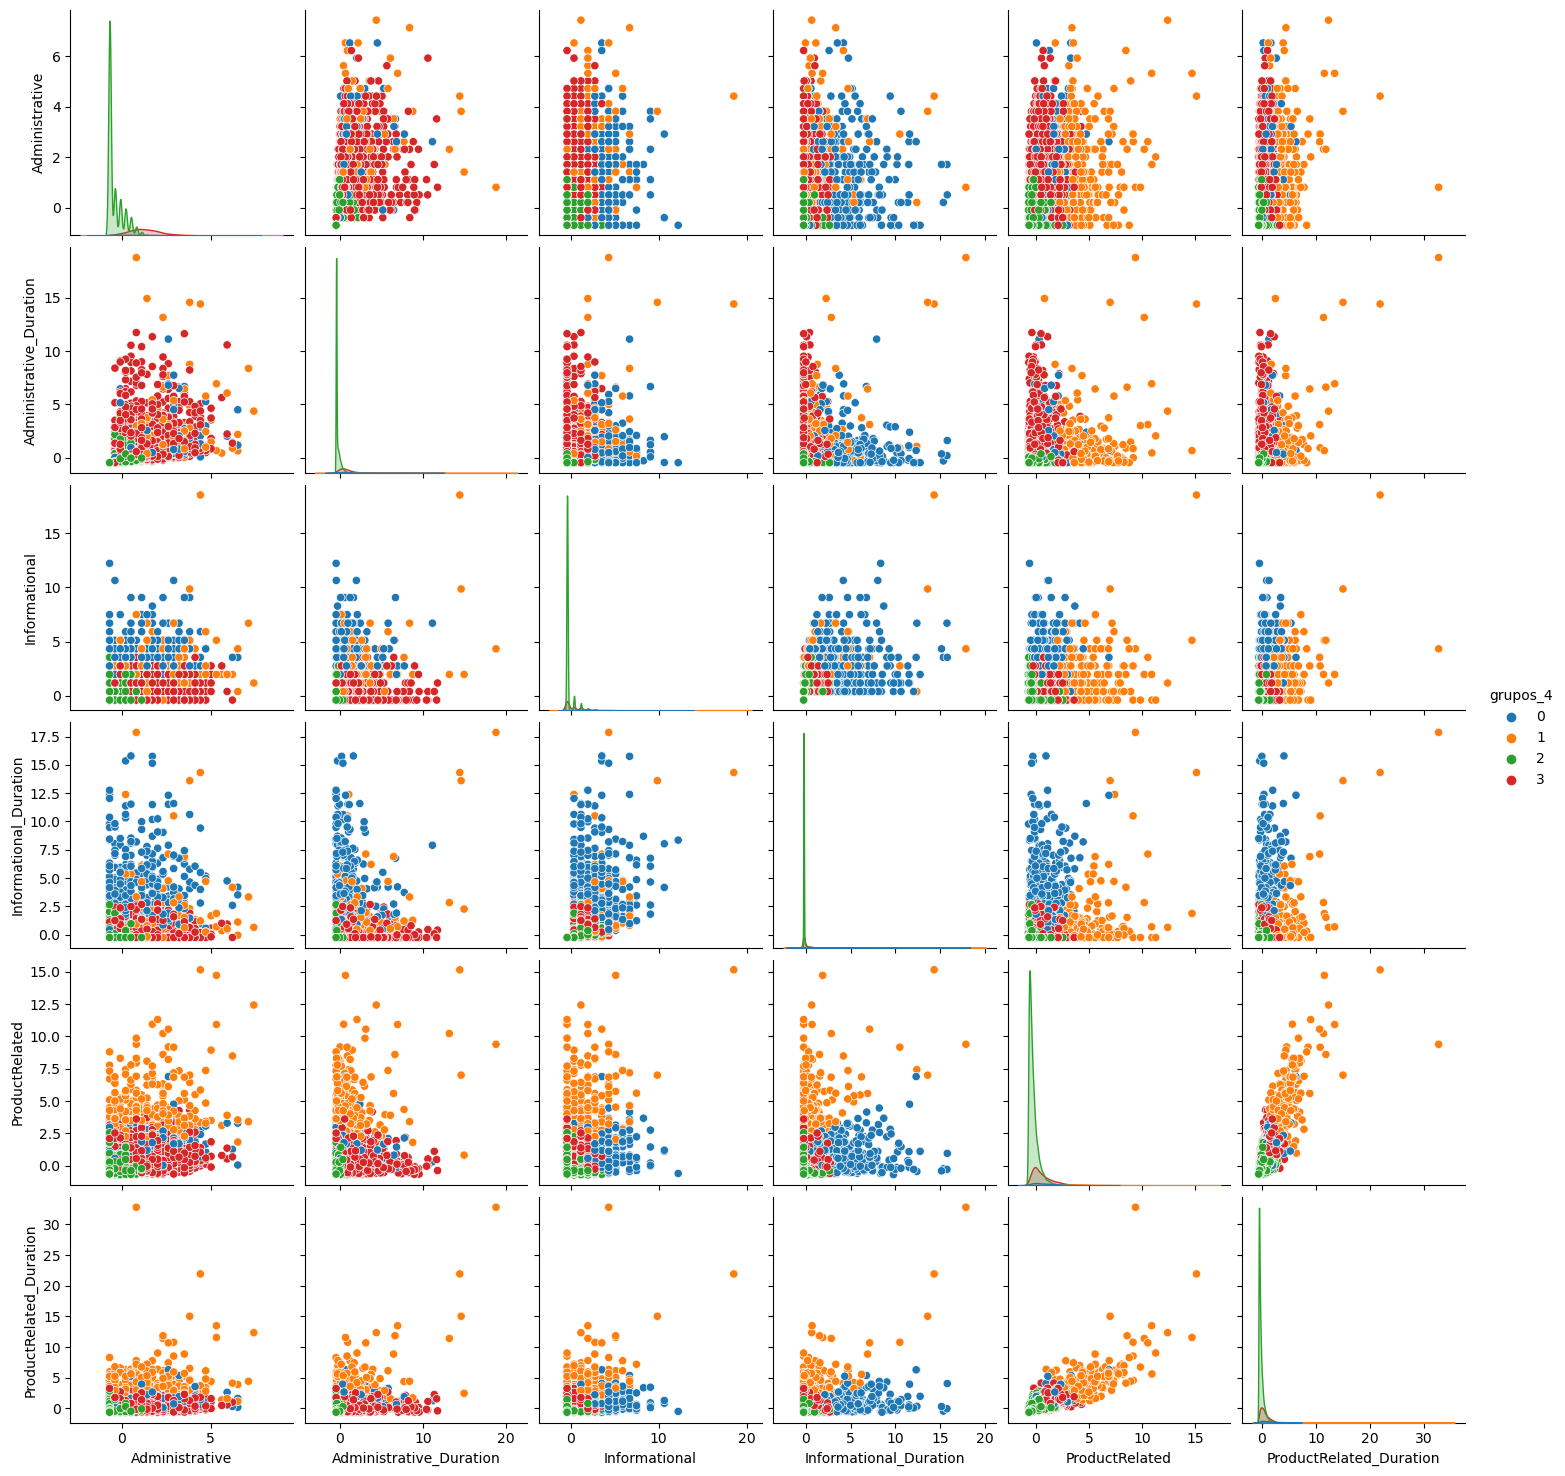

In [37]:
# Rodando algoritmo de clusterização (KMeans) para 4 clusters
cluster_4 = KMeans(n_clusters=4)
cluster_4.fit_predict(df_pad)

# Adicionando uma coluna no dataframe df_pad com o agrupamento construido
df_pad['grupos_4'] = pd.Categorical(cluster_4.labels_)

# Plotando resultado
sns.pairplot(df_pad, hue='grupos_4')
plt.show()

O modelo com 4 Clusters me parece o mais apropriado.

- O grupo 0 é composto por usuários que têm mais acessos e passa mais tempo em páginas informativas.
- O grupo 1 é caracterizado por usuários que têm um número de acessos baixo e também um tempo reduzido de permanência nas páginas informativas e administrativas. Porém, bom acesso em páginas de produtos. 
- O grupo 2 é composto por usuários que acessam com menor frequência todas as páginas.
- O grupo 3 é formado por usuários que acessam mais as páginas administrativas.

In [45]:
# Renomeando grupo
df_pad['grupos_4'].replace({0:"leads_informativos", 1:"leads_venda", 2:"leads_frios", 3:"leads_adm"}, inplace=True)
df_pad.groupby('grupos_4').mean()

C:\Users\Artur\AppData\Local\Temp\ipykernel_20792\1856099582.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pad.groupby('grupos_4').mean()


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration
grupos_4,,,,,,
leads_informativos,1.113248,0.732808,3.249810,4.021864,0.816673,0.894467
leads_venda,1.690114,1.312389,1.636958,0.974138,4.593107,4.349522
leads_frios,-0.403602,-0.307539,-0.269220,-0.202621,-0.280761,-0.258192
leads_adm,1.331511,1.031771,0.396167,0.054903,0.528816,0.447147


## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

In [51]:
df_pad.grupos_4.value_counts()

leads_frios           9466
leads_adm             2225
leads_informativos     385
leads_venda            254
Name: grupos_4, dtype: int64

<Axes: xlabel='BounceRates', ylabel='grupos_4'>

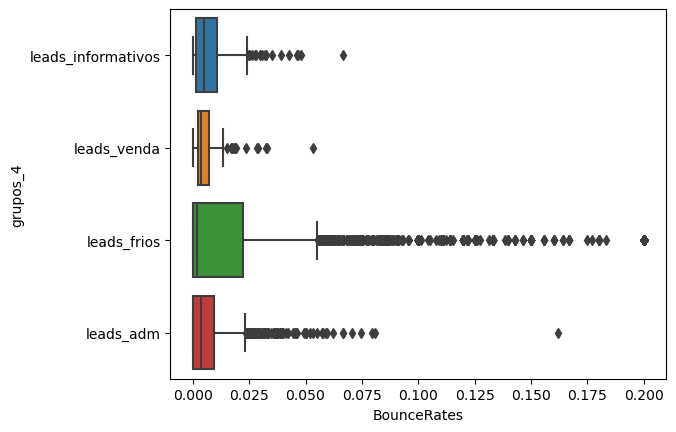

In [46]:
df_pad['BounceRates'] = df['BounceRates']
df_pad['Revenue'] = df['Revenue']

# Plotando a variável BounceRates em relação ao grupo 4
sns.boxplot(data=df_pad, y='grupos_4', x='BounceRates')

In [50]:
# Tabela cruzada entre Revenue e grupos_4
pd.crosstab(df_pad.Revenue, df_pad.grupos_4)

grupos_4,leads_informativos,leads_venda,leads_frios,leads_adm
Revenue,,,,
False,276,172,8276,1698
True,109,82,1190,527


In [52]:
# Porcentagem de True e False
pd.crosstab(df_pad.Revenue, df_pad.grupos_4, normalize='columns')

grupos_4,leads_informativos,leads_venda,leads_frios,leads_adm
Revenue,,,,
False,0.716883,0.677165,0.874287,0.763146
True,0.283117,0.322835,0.125713,0.236854


- O conjunto de consumidores com maior probabilidade de realizar compras é o grupo 1, intitulado de "leads_venda". Esse grupo apresenta maior visitas e tempo passado nas páginas dos produtos.Além disso, tem um bounce rate baixo e maior taxa de receita.